[PyMKS Blog link](http://materialsinnovation.github.io/pymks/rst/localization_cahn_hilliard_Legendre_2D.html)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [84]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pymks
from pymks.datasets.cahn_hilliard_simulation import CahnHilliardSimulation
from pymks.tools import draw_concentrations
from pymks.tools import draw_coeff
from pymks.bases import LegendreBasis
from pymks import MKSLocalizationModel

In [4]:
import time

In [5]:
def ch_test(length=51, time_steps = 10, seed = 99, dt =1e-1, gamma = 1., n_samples=1):
    np.random.seed(seed)
    size=(length, length)
    phi0 = np.random.normal(0, 1e-1, ((n_samples,) + size))
    phi_sim = phi0.copy()
    ch_sim = CahnHilliardSimulation(dt=dt)
    for steps in range(time_steps):
        ch_sim.run(phi_sim)
        phi_sim = ch_sim.response
    return phi0, phi_sim

In [6]:
def error(X, Y):
    n = X.shape[0]*X.shape[1]
    return (np.sum((X-Y)**2))

## Training the model

First Generate data for training the model.

First we need to generate the training data by executing cahn-hilliard simulation using spectral solver.
Below, we specify the model parameters for the Cahn-Hilliar Simulation of spinodal decomposition.

In [108]:
length     = 101 # size of domain
time_steps = 1 # Simulation time
seed       = 101 # seed for random no, generator for geenrating the initial microstructure
dt         = 1e-2 #simulation timestep
gamma      = 1. #gamma parameter value
training_samples = 200 # no. of training samples to be generated

Generating the training data using the simulation

In [109]:
%timeit X, y = ch_test(length, time_steps, seed, dt, gamma, training_samples)
# X, y = ch_test(length, time_steps, seed, dt, gamma, training_samples)

1 loop, best of 3: 23.3 s per loop


In [48]:
filename1 = "training_data_input_tstep_1_%d" % training_samples
np.save(filename1, X)
filename2 = "training_data_output_tstep_1_%d" % training_samples
np.save(filename2, y)
print(y.shape)

(200, 101, 101)


In [50]:
leg_basis = LegendreBasis(6, [-1, 1])
leg_model = MKSLocalizationModel(basis=leg_basis)

In [51]:
%timeit leg_model.fit(X, y)
leg_model.fit(X, y)

1 loop, best of 3: 5.38 s per loop


## Generating the test data

In [77]:
length     = 101 # size of domain
time_steps = 1 # Simulation time
seed       = 101 # seed for random no, generator for geenrating the initial microstructure
dt         = 1e-2 #simulation timestep
gamma      = 1. #gamma parameter value
test_samples = 50 # no. of training samples to be generated

In [78]:
%timeit X_test, y_test=ch_test(length, time_steps, seed, dt, gamma, test_samples)
X_test, y_test=ch_test(length, time_steps, seed, dt, gamma, test_samples)

1 loop, best of 3: 686 ms per loop


In [79]:
%timeit y_predict = leg_model.predict(X_test)
y_predict = leg_model.predict(X_test)

1 loop, best of 3: 978 ms per loop


In [104]:
phi_sim = y_predict.copy()
phi_predict = y_predict.copy()
y_predict.shape

(50, 101, 101)

# Comparing timestepping using predict to timestepping using spectral solver


In [88]:
%%time
for i in range(100):
    print(i)
    phi_predict = leg_model.predict(phi_predict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 1min 39s, sys: 20 ms, total: 1min 39s
Wall time: 1min 39s


On carrying out forward stepping using MKS_predict scheme, system takes 98 seconds to carry out 100 timsteps

    CPU times: user 1min 39s, sys: 20 ms, total: 1min 39s
    Wall time: 1min 39s

However, as can be seen below , on using Spectral_Solver scheme, system takes 67 seconds to carry out 100 timesteps

In [90]:
%%time
ch_sim = CahnHilliardSimulation(dt=dt)
for i in range(100):
    ch_sim.run(phi_sim)
    phi_sim = ch_sim.response

CPU times: user 1min 7s, sys: 136 ms, total: 1min 7s
Wall time: 1min 7s


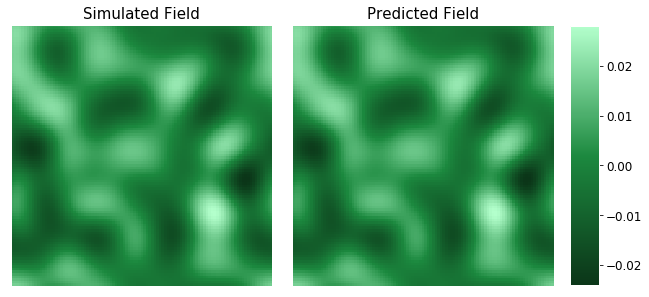

In [91]:
draw_concentrations([phi_sim[0], phi_predict[0]], ['Simulated Field', 'Predicted Field'])

## Training and testing the model

In [70]:
%%time
training_samples = 200
test_samples     = 10
errors           = np.zeros((training_samples-1,1))
training_times   = np.zeros((training_samples-1,1))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 23.8 µs


Choosing the model

In [13]:
%%time
leg_basis = LegendreBasis(10, [-1, 1])
leg_model = MKSLocalizationModel(basis=leg_basis)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 733 µs


In [76]:
for i in range(training_samples-1):
    indx = i+1
    start = time.clock()
    leg_model.fit(X[:indx], y[:indx])
    stop = time.clock()
    training_times[i] = stop-start
    y_predict = leg_model.predict(X_test)
    err = 0
    for j in range(test_samples):
        err = err+error(y_predict[j],y_test[j])
    err = err/test_samples
    errors[i] = err
    print(indx, training_times[i][0], errors[i][0])
print("End of Trainng run")

1 0.692219 1.02255343076
2 0.76051 0.156969216228
3 0.797564 0.00504795720471
4 0.786315 0.000414219009985
5 0.806719 0.00031460968092
6 0.834502 0.000266984891422
7 0.859158 0.000281035459276
8 0.873111 0.000266033719732
9 0.882527 0.000265926397261
10 0.895226 0.000255304248584
11 0.907762 0.000247308066246
12 0.918032 0.000262548014869
13 0.931826 0.000252625276238
14 0.949302 0.000252324202479
15 0.983534 0.00024292357053
16 0.985662 0.000249969949691
17 0.993931 0.000241400713058
18 1.00591 0.000237238824928
19 1.016035 0.000234679022731
20 1.028856 0.00023243123951
21 1.04343 0.000229890505822
22 1.059899 0.000224431496449
23 1.068698 0.000221704151779
24 1.088731 0.000220735331902
25 1.102911 0.000219505723406
26 1.1175 0.00022919732595
27 1.130406 0.000232923258542
28 1.16984 0.000230723804059
29 1.199309 0.000227088316764
30 1.189425 0.000223813927914
31 1.194681 0.000222042036884
32 1.202826 0.000220377767036
33 1.215596 0.000216639349245
34 1.228511 0.000216900021118
35 1.26

In [88]:
np.save("training_errors", errors)
np.save("training_times", training_times)

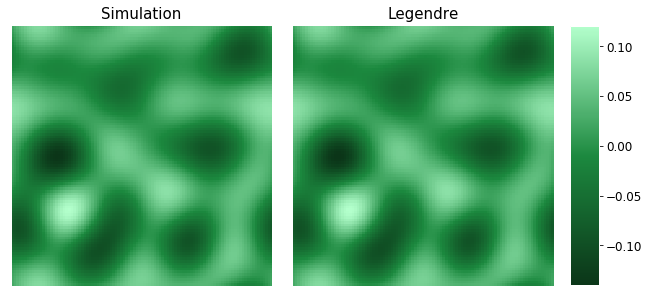

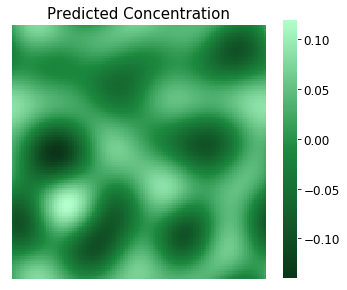

In [77]:
draw_concentrations((y_test[0], y_predict[0]),
                    ('Simulation', 'Legendre'))
draw_concentrations([y_predict[0]], ['Predicted Concentration'])

In [80]:
samples = np.reshape(np.arange(499),(499,1))

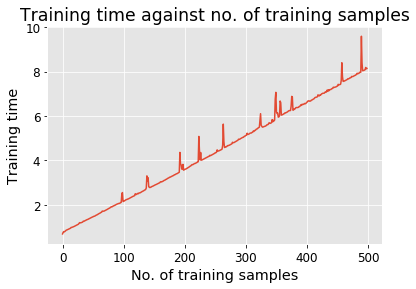

In [87]:
plt.plot(samples, training_times)
plt.title("Training time against no. of training samples")
plt.ylabel("Training time")
plt.xlabel("No. of training samples")
plt.show()

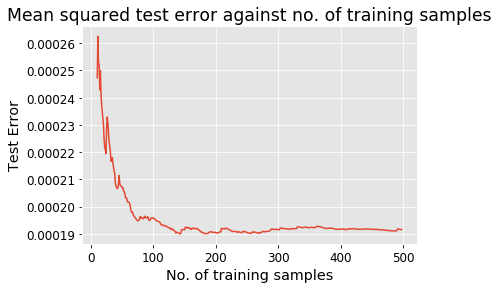

In [86]:
plt.plot(samples[10:], errors[10:])
plt.title("Mean squared test error against no. of training samples")
plt.ylabel("Test Error")
plt.xlabel("No. of training samples")
plt.show()

(400, 101, 101)


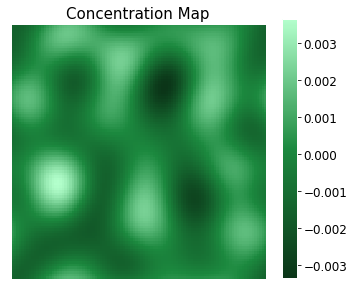

In [96]:
tsteps = 499
filename = "data/phi_101_%d.npy" % tsteps
phi = np.load(filename)
print(phi.shape)
draw_concentrations([phi[0]], ['Concentration Map'])

In [97]:
%%time
leg_basis = LegendreBasis(4, [-1, 1])
leg_model = MKSLocalizationModel(basis=leg_basis)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.9 ms


In [ ]:
leg_model.fit(X[:indx], y[:indx])
stop = time.clock()
training_times[i] = stop-start
y_predict = leg_model.predict(X_test)
err = 0
for j in range(test_samples):
    err = err+error(y_predict[j],y_test[j])
    err = err/test_samples
errors[i] = err
print(indx, training_times[i][0], errors[i][0])
print("End of Trainng run")